In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU

In [45]:
#load DATA
company = 'DELL'

start = dt.datetime(2000,1,1)
end = dt.datetime(2021,2,15)

data = web.DataReader(company, 'yahoo', start, end)

In [46]:
#Prepare Data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

window_days = 20

x_train = []
y_train = []

for i in range(window_days, len(scaled_data)):
    x_train.append(scaled_data[i-window_days:i, 0])
    y_train.append(scaled_data[i, 0])


    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 

In [47]:
#Build The Model
model = Sequential()

model.add(GRU(units = 200, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units = 100, return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #final prediction

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 1, batch_size = 1)

1111/1111 [==============================] - 13s 9ms/step - loss: 0.0114


In [48]:
#save and load model on local drive
model.save('models/GRU_for_price_predicions')
#model = keras.models.load_model('models/GRU_for_price_predicions')

INFO:tensorflow:Assets written to: models/GRU_for_price_predicions/assets


INFO:tensorflow:Assets written to: models/GRU_for_price_predicions/assets


In [49]:
'''Accuracy Test'''

#Load test Data
test_start = end #dt.datetime(2021,10,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values 

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

#Prepare Data
model_inputs = total_dataset[len(total_dataset) - len(test_data) - window_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


x_test = []
for i in range(window_days, len(model_inputs)):
    x_test.append(model_inputs[i-window_days:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [50]:
#prediction by RNN
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

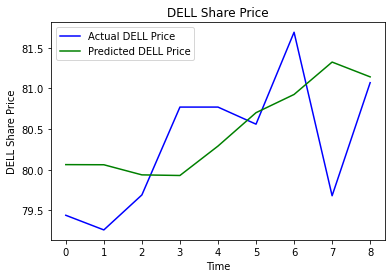

In [51]:
#check on plot
plt.plot(actual_prices, color = 'b', label = f'Actual {company} Price')
plt.plot(predicted_prices, color = 'g', label = f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [52]:
# a few days ahead
real_data = [model_inputs[len(model_inputs) + 1 - window_days : len(model_inputs+1), 0]]

real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [53]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

print(f'Prediction: {prediction}')

Prediction: [[81.13529]]
